<center><h1>Machine Learning Model Pipeline</h1></center>

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option('display.max_columns', None)

# System Settings
import warnings
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath('../atmoseer'))
sys.path.append(os.path.abspath('../utils'))
warnings.filterwarnings("ignore")

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Database Operations
from utils.postgres_processor import load_table

In [2]:
co2_df = load_table("CO2DataNOAA", "postgres", "Godragons6")
co2_df.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

,date,site,ppm,latitude,longitude,altitude,year,month,day,season,co2_change_rate,month_sin,month_cos,ppm_lag_14,ppm_lag_30,ppm_lag_365,biomass_density
0,1968-01-16,NWR,324.38,40.05,-105.63,3526.00,1968,1,16,Winter,1.50,0.50,0.87,324.38,324.38,324.38,328352893.44
1,1968-01-17,NWR,323.69,40.05,-105.63,3526.00,1968,1,17,Winter,-0.16,0.50,0.87,324.38,324.38,324.38,328352893.44
2,1968-02-29,NWR,325.53,40.05,-105.63,3526.00,1968,2,29,Winter,1.84,0.87,0.50,324.38,324.38,324.38,736124172.48
3,1968-03-07,NWR,326.49,40.05,-105.63,3526.00,1968,3,7,Spring,0.96,1.00,0.00,324.38,324.38,324.38,1143895451.52
4,1968-03-14,NWR,326.09,40.05,-105.63,3526.00,1968,3,14,Spring,-0.40,1.00,0.00,324.38,324.38,324.38,1143895451.52


<center><h1>Preprocessing</h1></center>

## Categorical Encoding

In [3]:
site_encoder = LabelEncoder()
season_encoder = LabelEncoder()

co2_df['site'] = site_encoder.fit_transform(co2_df['site'])
co2_df['season'] = season_encoder.fit_transform(co2_df['season'])

## Continuous Feature Scaling

Cyclical and lag features will stay as is.

In [4]:
numeric_features = ['latitude', 'longitude', 'altitude', 'co2_change_rate', 'biomass_density']
scaler = StandardScaler()
co2_df[numeric_features] = scaler.fit_transform(co2_df[numeric_features])

## Final Feature Selection
These features are designed with a BiLSTM in mind, where both short and long term dependencies are retained. The standard date and day columns are not needed as the temporal patterns will be captured through patterns based on the time of year, not time of month.

<Figure size 1200x1000 with 0 Axes>

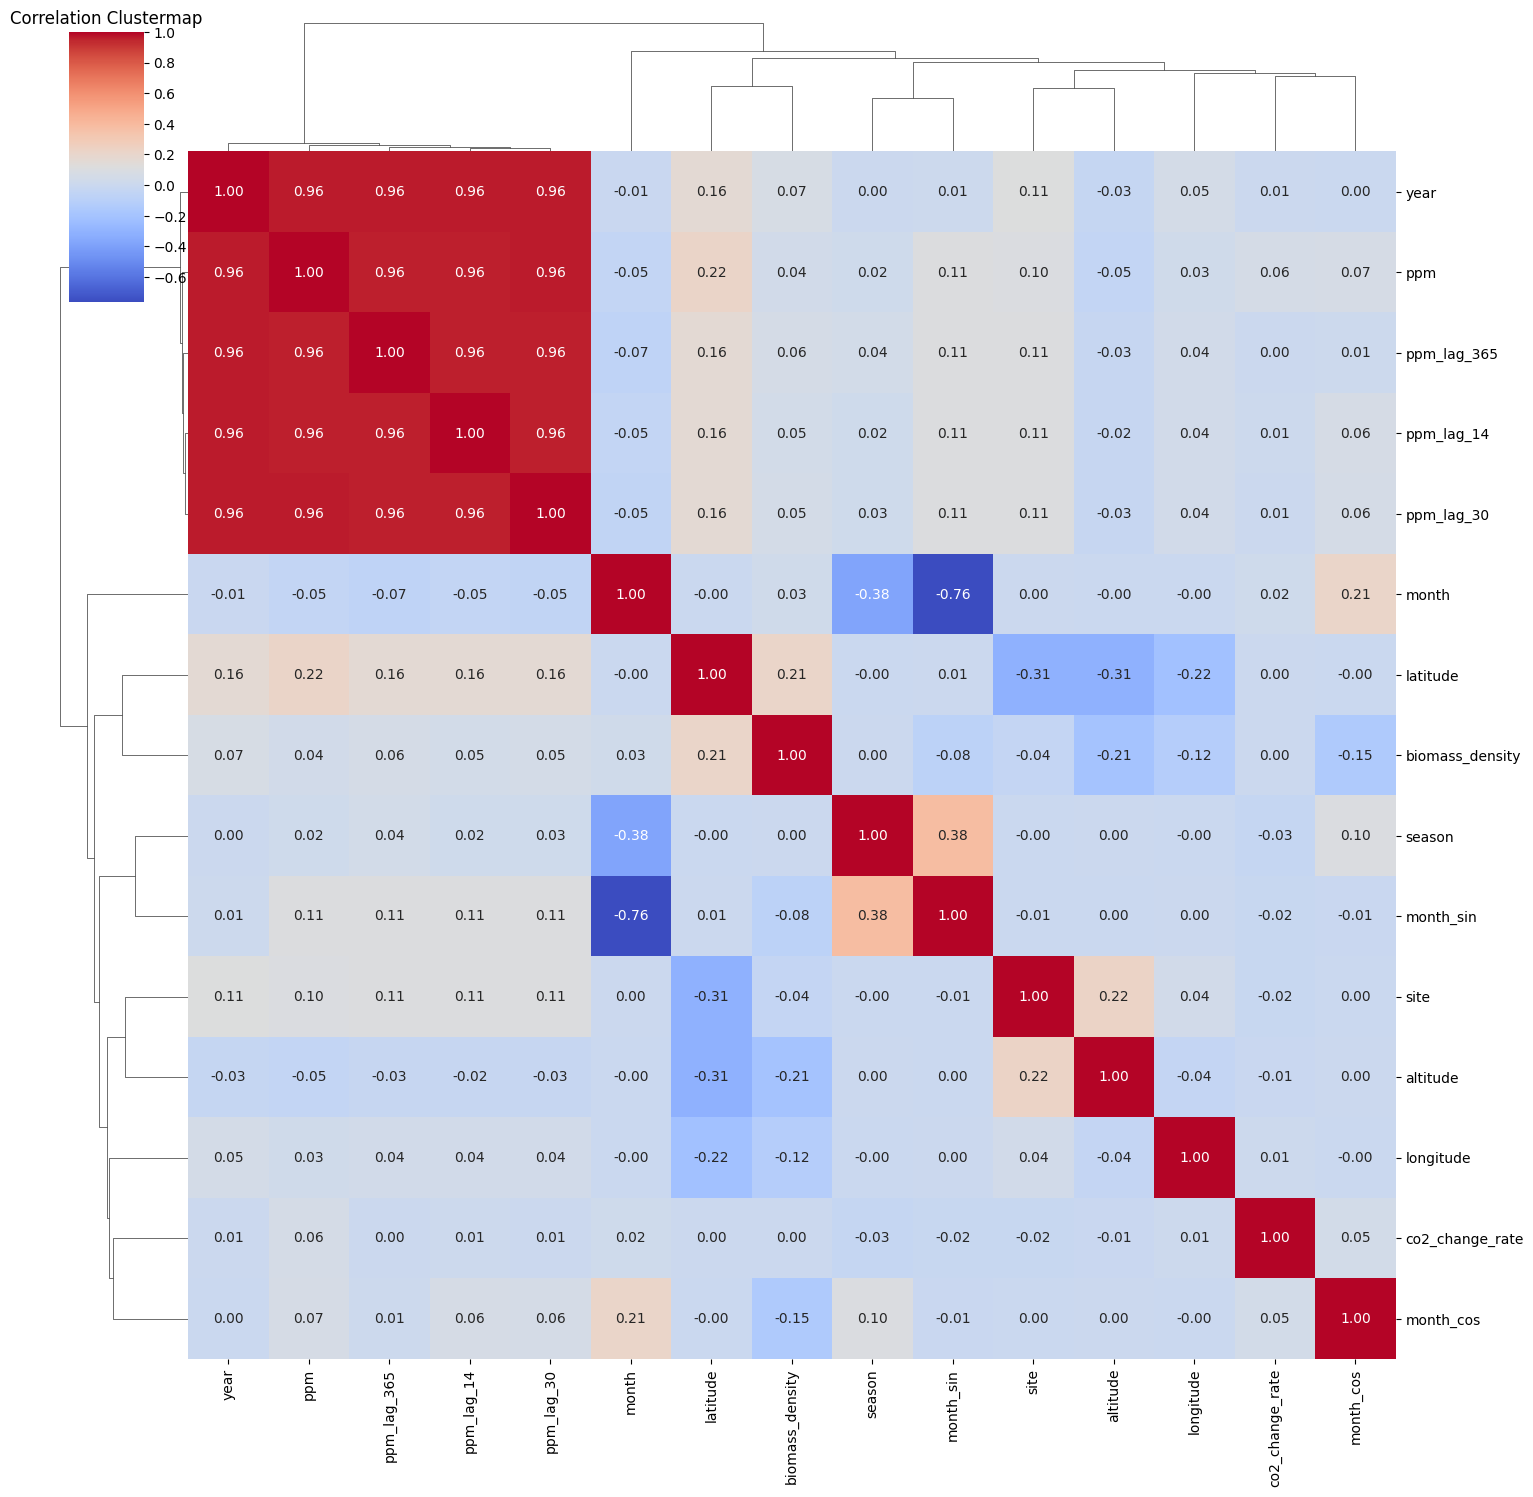

In [ ]:
plt.figure(figsize=(12, 10))

df = co2_df.drop(columns=['date', 'day'])
corr_matrix = df.corr()
corr_matrix = corr_matrix.fillna(0)

sns.clustermap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    figsize=(15, 15),
    dendrogram_ratio=(.1, .1)
)
plt.title('Correlation Clustermap')
plt.show()

In [4]:
X = co2_df.drop(columns=['date', 'day', 'ppm'])
y = co2_df['ppm']

X.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

,site,latitude,longitude,altitude,year,month,season,co2_change_rate,month_sin,month_cos,ppm_lag_14,ppm_lag_30,ppm_lag_365,biomass_density
0,67,40.05,-105.63,3526.00,1968,1,3,1.50,0.50,0.87,324.38,324.38,324.38,328352893.44
1,67,40.05,-105.63,3526.00,1968,1,3,-0.16,0.50,0.87,324.38,324.38,324.38,328352893.44
2,67,40.05,-105.63,3526.00,1968,2,3,1.84,0.87,0.50,324.38,324.38,324.38,736124172.48
3,67,40.05,-105.63,3526.00,1968,3,1,0.96,1.00,0.00,324.38,324.38,324.38,1143895451.52
4,67,40.05,-105.63,3526.00,1968,3,1,-0.40,1.00,0.00,324.38,324.38,324.38,1143895451.52


Excellent, this data is cleaned, sorted, normalized, and encoded.